<a href="https://colab.research.google.com/github/BillXu21/culvert-identification/blob/main/CNN_Curv%2BHRDEM%2BTPI21_(94.6%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install rasterio

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from skimage import io
import glob

from sklearn.model_selection import train_test_split
# import tensorflow as tf

import tensorflow as tf

import numpy as np
import pandas as pd


#from tensorflow.keras.callbacks import TensorBoard
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.layers import *
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.compat.v1.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.compat.v1.keras.optimizers import Adadelta, Adam
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

#from tensorflow.keras import callbacks
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path='/content/drive/MyDrive/WFBBDEM/WFBBDEM+/'   #DEM

# using one watershed to train model, 3 of them to test
pathTrain='WFBBDEM_Train/'
pathTest1='WFBBDEM_Test/'
ca = 'CADEM/'
il = 'ILDEM/'
nd = 'NDDEM/'
newfbb = 'NEWFBB_DEM/'

In [ ]:
# import rasterio as rio
# def read_img(path):
#     cate=[path+x for x in os.listdir(path) if os.path.isdir(path+x)] # get F,T folder
#     imgs=[]
#     labels=[]
#     imgs_name=[]
#     for idx,folder in enumerate(cate): # idx-> 0:F; 1:T; folder-> F,T
#         print(idx,folder)
#         for im in glob.glob(folder+"/*.tif"):
#             im = im.replace('\\','/')
# #            print('reading the images:%s'%(im))

#             img_name=os.path.basename(im)
#             img_name=os.path.splitext(img_name)[0] # get file name

#             #img=io.imread(im)
#             with rio.open(im) as i:
#               img = i.read()
#             # Normalize the dataset-MaxMin
#             img = np.squeeze(img)
#             scaler = MinMaxScaler(feature_range=(0, 1))
#             img = scaler.fit_transform(img)

#             imgs.append(img)
#             labels.append(idx)
#             imgs_name.append(img_name) # image name

#     return np.asarray(imgs,np.float32),np.asarray(labels,np.int32), np.asarray(imgs_name)

# data1,label1,name1=read_img('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/')

In [ ]:
# import pickle
# with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/data','wb') as fin: pickle.dump(data1,fin)
# with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/label','wb') as fin: pickle.dump(label1,fin)
# with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/name','wb') as fin: pickle.dump(name1,fin)

In [ ]:
import pickle
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/data','rb') as fin: data1 = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/label','rb') as fin: label1 = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/TPI_21_DATA/name','rb') as fin: name1 = pickle.load(fin)

with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Cuvature/data','rb') as fin: data3 = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Cuvature/label',  'rb') as fin: label3 = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Cuvature/name','rb') as fin: name3 = pickle.load(fin)

with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/NEWFBB_DEM/data','rb') as fin: data5 = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/NEWFBB_DEM/label','rb') as fin: label5 = pickle.load(fin)
with open('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/NEWFBB_DEM/name','rb') as fin: name5 = pickle.load(fin)

In [ ]:
datas = [[data1,label1,name1],[data3,label3,name3],[data5,label5,name5]]

In [ ]:
#data=np.expand_dims(data,3) # add channel dimension, 4D
temp = []
for data,label,name in datas:
  #data = np.repeat(data[..., np.newaxis], 3, -1)

  labelN=label.shape[0]


  label_name=np.empty((labelN,2),dtype=int) # label + name
  for i in range(labelN):
      label_name[i,0]=label[i] # label
      if (name[i].isdigit()):
          name[i]=name[i]
      else:
          name[i]=name[i][1:] # only keep number, delete first letter
      name[i] = name[i].split()[0]
      label_name[i,1]=name[i]
  temp.append([data,label,name,label_name])
datas = temp

In [ ]:
data = []
for i in datas:
  temp = list(sorted(zip(*map(list,i)),key=lambda x:x[2]))
  data.append(temp)
datas = data

In [ ]:
tt = list(zip(*datas))
data = np.asarray([[i[0] for i in q] for q in tt])

label_name = [q[0][3] for q in tt]

In [ ]:
data.shape

(4044, 3, 100, 100)

In [ ]:
train_data,test_data,train_label,test_label = train_test_split(data,label_name,test_size=0.2,stratify=label)

In [ ]:
train_data.shape

(3235, 3, 100, 100)

In [ ]:
# creat CNN model
def createCNN():
    inputs = [keras.layers.Input(shape = (100,100,1)) for i in range(3)]
    merged = keras.layers.Concatenate()(inputs)
    a = Convolution2D(128,3,3,padding='same')(merged)
    b = BatchNormalization()(a)
    c = Activation('relu')(b)
    d = Dropout(0.3)(c)

    e = Convolution2D(256,3,3,padding='same')(d)
    f = BatchNormalization()(e)
    g = Activation('relu')(f)
    h = Dropout(0.3)(g)

    i = Convolution2D(512,3,3,padding='same')(h)
    j = BatchNormalization()(i)
    k = Activation('relu')(j)
    l = Dropout(0.3)(k)

    flat = Flatten()(l)

    m = Dense(512,activation = 'relu')(flat)
    n = Dropout(0.5)(m)
    o = Dense(128,activation = 'relu')(n)
    p = Dropout(0.5)(o)
    q = Dense(32,activation = 'relu')(p)
    r = Dropout(0.5)(q)
    s = Dense(2,activation = 'softmax')(r)

    model = keras.models.Model(inputs = inputs, outputs = s)

    # model.summary()

    return model

In [ ]:
train_data.shape

(3235, 3, 100, 100)

In [ ]:
train_data = np.expand_dims(train_data,axis=4)

In [ ]:
train_label[0]

array([   0, 1784])

In [ ]:
LEARNING_RATE = 1e-21
BATCH_SIZE = 64
EPOCHS = 20


model = createCNN()

model.load_weights('/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Model3CNN20.h5')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=LEARNING_RATE),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
import gc
gc.collect()

292

In [ ]:
from itertools import chain

In [ ]:
np.asarray(train_label)[:,0].shape

(3235,)

In [ ]:
OUT_DIR = "/content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM"
checkpoint = ModelCheckpoint(os.path.join(OUT_DIR, 'Model3CNN21.h5'),  # model filename
                              monitor='val_accuracy', # quantity to monitor
                              verbose=1, # verbosity - 0 or 1
                              save_best_only= True, # The latest best model will not be overwritten
                              save_weights_only=True, # save model, not only weights
                              mode='auto') # The decision to overwrite model is made
                                            # automatically depending on the quantity to monitor

model_details = model.fit([train_data[:,i] for i in range(3)], np.asarray(train_label)[:,0],
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          validation_split=0.2,
                          callbacks=[checkpoint],
                          verbose=1)


Train on 2588 samples, validate on 647 samples
Epoch 1/20
2560/2588 [============================>.] - ETA: 0s - loss: 0.2632 - accuracy: 0.9074

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_accuracy improved from -inf to 0.93818, saving model to /content/drive/MyDrive/WFBBDEM/WFBBDEM+/NEWFBB_DEM/Model3CNN21.h5
2588/2588 [==============================] - 6s 2ms/sample - loss: 0.2656 - accuracy: 0.9065 - val_loss: 0.1510 - val_accuracy: 0.9382
Epoch 2/20
2588/2588 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9007
Epoch 2: val_accuracy did not improve from 0.93818
2588/2588 [==============================] - 2s 777us/sample - loss: 0.2580 - accuracy: 0.9007 - val_loss: 0.1508 - val_accuracy: 0.9382
Epoch 3/20
2588/2588 [==============================] - ETA: 0s - loss: 0.2603 - accuracy: 0.9080
Epoch 3: val_accuracy did not improve from 0.93818
2588/2588 [==============================] - 2s 726us/sample - loss: 0.2603 - accuracy: 0.9080 - val_loss: 0.1506 - val_accuracy: 0.9382
Epoch 4/20
2588/2588 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.9038
Epoch 4: val_accuracy improved from 0.93818 to 0.93972, sav

In [ ]:
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat,interpolation='nearest',cmap=plt.cm.Wistia)
    plt.title('CNN Confusion Matrix',fontsize=20)
    plt.colorbar()
    tick_marks=np.arange(2) # class number
    plt.xticks(tick_marks,tick_marks,fontsize=16)
    plt.yticks(tick_marks,tick_marks,fontsize=16)
    plt.ylabel('True Label',fontsize=16)
    plt.xlabel('Predicted Label',fontsize=16)
    for i in range(len(confusion_mat)):    #row
        for j in range(len(confusion_mat[i])):    #col
            plt.text(j, i, confusion_mat[i][j],fontsize=16) # images number of each part
    plt.show()

def plot_learning_curves(history):
    df=pd.DataFrame(history.history,index=np.arange(0, EPOCHS).astype(dtype=np.str))
    df.plot(use_index=True,figsize=(8, 5))
    plt.grid(True)

    #plt.gca().set_ylim(0, 1)
    plt.show()

In [ ]:
test_label = np.asarray(test_label)

In [ ]:
test_data = np.expand_dims(test_data,4)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


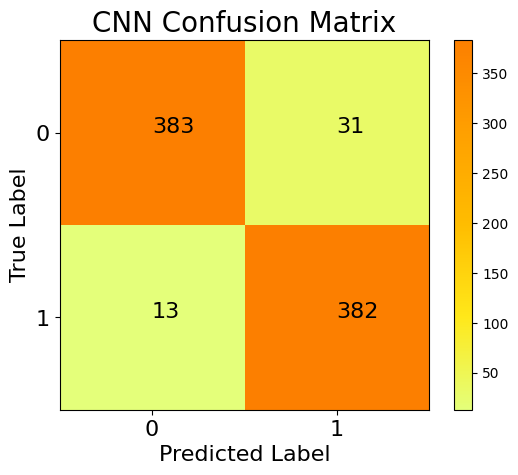

Accuracy: 0.9456 Loss: 0.1438 Precision: 0.9460555922420328 Recall: 0.9461046902708983 F1: 0.9460801406194644 Batch Size: 64 Learning Rate: 1e-21 Epochs: 20


In [ ]:
# Predict
scroe, accuracy = model.evaluate([test_data[:,i] for i in range(3)], test_label[:,0], batch_size=BATCH_SIZE)
pred_label = model.predict([test_data[:,i] for i in range(3)])
#pred_label = [sum([i[0] for i in q]) for q in test_data]
pred_label = np.argmax(pred_label, axis=1)


for t in range(pred_label.shape[0]):
    NameWrong=[]
    labelPred=[]
    if (pred_label[t]!=test_label[t,0]):
        # print (test_label[t,0], test_label[t,1], pred_label[t])
        NameWrong.append(test_label[t,1])
        labelPred.append(pred_label[t])
confusion_matrix = tf.math.confusion_matrix(labels=test_label[:,0],predictions=pred_label, num_classes=2, dtype=tf.int32, name=None, weights=None)
sess=tf.compat.v1.Session()

#with tf.compat.v1.Session(graph=g) as sess:
confusion_matrix = sess.run(confusion_matrix)
plot_confusion_matrix(confusion_matrix)

#plot_learning_curves(model_details)
precision = (confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0])+confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]))/2
recall = (confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1])+confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))/2
F = 2*(precision*recall)/(precision+recall)
print ('Accuracy:', '{:.4f}'.format(accuracy), 'Loss:','{:.4f}'.format(scroe), f'Precision: {precision}', f'Recall: {recall}', f'F1: {F}', 'Batch Size:', BATCH_SIZE,'Learning Rate:', LEARNING_RATE, 'Epochs:', EPOCHS)


In [ ]:
lol

NameError: name 'lol' is not defined

In [ ]:
for i in range(3):
  s = 0
  test = test_data.copy()
  for q in range(100):
    np.random.shuffle(test[:,i])
    scroe, accuracy = model.evaluate([test[:,i] for i in range(3)], test_label[:,0], batch_size=512)
    s += .9419-accuracy
  print(s/100)

In [ ]:
x_test = test_data
y_test = test_label[:,0]

In [ ]:
lol

In [ ]:
!pip install shap

In [ ]:
import shap
explainer = shap.DeepExplainer(model,[test_data[:50,i] for i in range(5)])
shap.initjs()

In [ ]:
shap_value = explainer.shap_values([test_data[:1,i] for i in range(5)])
shap_value = np.squeeze(np.asarray(shap_value))

In [ ]:
shap_value.shape

In [ ]:
shap.summary_plot(shap_value[1])

In [ ]:
test_data.shape

In [ ]:
shap_value.shape

In [ ]:
test_data.shape

In [ ]:
for i in range(5):
  # shap.image_plot([shap_value[0,:,:,i:i+1],shap_value[1,:,:,i:i+1]],test_data[0,:,:,i:i+1])
  shap.image_plot(shap_value[1,:,:,i:i+1],test_data[0,i,:,:,0])
  # shap.image_plot(shap_value[0,:,:,i:i+1],test_data[0,:,:,i:i+1])

In [ ]:
shap_value.shape

In [ ]:
explainer

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0],shap_value[0,:,:,0])